# Homework 3 - Waves in elastic medium
Due May 3rd, 2024

## 1) Apparent velocity
Consider a harmonic planewave p-wave propogating along the x-z plane:

$$
\phi(x, z, t) = A e^{i(\omega t - k_x x + k_z z)} \hspace{20pt} (1)
$$

where are usual, $\omega$ is the angular frequency and $k_x$ and $k_z$ are the wavenumbers (which all must be positive values).

### a)
Which direction is the wave traveling (what is $\vec{k}$)?

### b)
What is the speed of this wave in terms of $\omega$, $k_x$, and $k_z$? (Recall the relationship between $\omega$ and $|\vec{k}|$)

### c)
What is the $x$ component of the $\hat{k}$ (the unit vector in the direction of $\vec{k})$?

### d)
What is the x-component of the wave's velocity, (the vector $\vec{v} = v \hat{k}$, so what is its x-component.)

### e)
What is the equation for the wave as it intersects a plane at $z=0$? (what is (1) with $z=0$)?

### f)
Which direction is the wave "apparently" traveling along the plane at $z=0$?

### g)
What is the "apparent velocity" of the wave along the plane at $z=0$? (What is the speed of the wave from your equation in part 6?)

### h)
How does the apparent velocity of the wave along the plane at $z=0$ compare to the true $x$ component of the wave's velocity (is it smaller or larger?)

### i)
Under what condition will the two be equal to each other? (Hint: there's a specific value of $k_z$ such that $v_{apparent} = v_x$)

### j)
What is the apparent velocity of the wave for $k_z>>k_x$ (The limit of $v_{apparent}$ as $k_x \rightarrow 0$)?

## 2) Numerical solutions
Consider the following 1D partial differential equation for $u_y$, describing the motion of waves along a string with non-constant velocity ($v$) (but a constant density):

$$
\frac{\partial}{\partial x} v(x)^2 \frac{\partial u_y}{\partial x} + h(x,t)= \frac{\partial^2 u_y}{\partial t^2}
$$
subject to initial conditions on $u_y(x, t=0)$ and boundary conditions on $u_y(x=0, t)$ and $u_y(x=L, t)$, which will be given. $h$ is a source function.

This is a general form of our equation of motion for elastic medium (but only in 1D). It describes wave motion through an inhomogenous medium.

There are three primary approximations to derivatives that make up the basis of numerical solutions to PDE's:

They are:

* The forward difference approximation to the first derivative of a function,
$$f'(x) \approx \frac{f(x+\Delta x) - f(x)}{\Delta x}$$
* The backwards difference approximation to the first derivative of a function,
$$f'(x) \approx \frac{f(x) - f(x-\Delta x)}{\Delta x}$$
* The centered second difference approximation to the second derivative of a function,
$$f''(x) \approx \frac{f(x-\Delta x) - 2 f(x) + f(x + \Delta x)}{\Delta x^2}$$

### a)
Use a first order taylor expansion on $f(x+\Delta x)$ to verify the forward difference approximation to $f'(x)$.

### b) 
Let's define our forward difference operator that approximates the derivative of function $f$ at grid point $i$, in terms of the value of $f$ at the grid points ($f_i$):
$$\delta_+ f = \frac{f_{i+1} - f_i}{\Delta}
$$

Similarly the backwards difference operator is:

$$\delta_- f = \frac{f_{i} - f_{i-1}}{\Delta}
$$

and the centered second derivative operator is:
$$
\delta^2 f = \frac{f_{i-1}  - 2 f_i + f_{i+1}}{\Delta^2}
$$

**Show** that $\delta^2 f = \delta_- (\delta_+ f)$

(Hint: Start by defining $(\delta_+ f)_i = g_i$ and applying the backward difference to $g$,  $\delta_- g$)

\begin{align}
g_i = (\delta_+ f)_i &= \frac{f_{i+1} - f_i}{\Delta}\\
(\delta_- g)_i &= \frac{g_{i} - g_{i-1}}{\Delta}\\
\end{align}

## Numerical implementation:
For the next few parts of this question here's a few bits of information:

Let us define a few quantities:

   * a grid of time coordinates for $t$ such that:
       $$ t_j = t_0 + j \Delta t $$
   * a grid of spatial coordinates for $x$ such that:
       $$ x_k = x_0 + k \Delta x $$
   * The value of $u$ at $t_j$ and $x_k$
     $$u_k^j = u(t_j, x_k)$$
   * The value of $v$ at $x_k$ as:
     $$v_k = v(x_k)$$

If we use the approximations to the derivatives to write our numerical approximation to the PDE we will write this as:

$$
\delta_- (v^2 \delta_+ u) = \delta^2 u
$$

which when expanded completly out yields our discretized PDE:

$$
 \frac{1}{\Delta x}\bigg(v^2_k \frac{u_{k+1}^j - u_{k}^j}{\Delta x} - v^2_{k-1} \frac{u_{k}^j - u_{k-1}^j}{\Delta x}\bigg) = \rho \frac{u_k^{j-1} - 2 u_k^j + u_k^{j+1}}{\Delta t^2}
$$

We solve this by stepping through time in a forward Euler method, rearranging the above equation to isolate $u^{j+1}_k$:

\begin{align}
u^{j+1}_k &= \frac{\Delta t^2}{\Delta x^2}\bigg(v^2_k (u_{k+1}^j - u_{k}^j) - v^2_{k-1} (u_{k}^j - u_{k-1}^j)\bigg) - u^{j-1}_k + 2 u^{j}_k
\end{align}

Essentially we provide some initial conditions on $u_k^{0}$ and $u_k^{1}$ and some boundary information for $u_{0}^j$ and $u_{N}^j$, and loop!

#### Implementation:

I have provided you with a simple simulation script, that uses a free boundary at on the left (0 Nuemann) and a fixed boundary on the right (0 dirichlet).

In [324]:
import numpy as np
import matplotlib.pyplot as plt

In [325]:
def wave_simulator(
    x_grid, t_grid, velocity,
    pulse_period=0.025, pulse_time=0.05,
    pulse_width=5, pulse_location=20, auto_scale=True
):
    n_t = len(t_grid)
    n_x = len(x_grid)
        
    dt = t_grid[1] - t_grid[0]
    dx = x_grid[1] - x_grid[0]
    u = np.empty((n_t, n_x))
    u[:, -1] = 0 # the boundary at the end of the rope is a 0 dirichlet
    u[:, 0] = 0

    a = dt**2/dx**2

    # use u(t=0)=0, u't(t=0)=0
    # basically it means that nothing is happening until we force it.
    ujm2 = np.zeros(n_x)
    ujm1 = ujm2

    pulse_window = np.zeros(n_x)
    arg = (x_grid-pulse_location)* 2 * np.pi / pulse_width
    in_windows = np.where((arg > -np.pi) & (arg < np.pi))
    arg = arg[in_windows]
    pulse_window[in_windows] = (np.cos(arg)+1)
    
    def f(t):
        arg = (t-pulse_time)* 2 * np.pi / pulse_period
        if arg > -np.pi and arg < np.pi:
           return pulse_window * -np.sin(arg)
        return 0

    for j in range(n_t):
        ujm1[0] = ujm1[1]
        gj = velocity[:-1]**2*(ujm1[1:] - ujm1[:-1])

        u[j, 1:-1] = (
            a * (gj[1:]- gj[:-1])
            + 2 * ujm1[1:-1] - ujm2[1:-1]
        )
        u[j] += dt**2 * f(t_grid[j])

        ujm2 = ujm1
        ujm1 = u[j]
    if auto_scale:
        u /= max(np.abs(u.min()), np.abs(u.max()))
    return u

## Solving it
Here I have set up a grid with $\Delta_x=0.5$m from 0 to 200m, $\Delta t=0.001$s, from 0 to 2 seconds, and a constant velocity of $v_1=500 m/s$.

The forcing function is also defined in terms of a time, length, and location. The force is applied at $x=20$m.

In [326]:
# define the grid points
xs = np.linspace(0, 200, 401)
ts = np.linspace(0, 2, 2001)

v1 = np.ones_like(xs)*500 # m/s

### c)
What is the value of $\frac{\Delta t}{\Delta x} v$?

### d)
Run the "wave simulator" with these simple parameters, and answer some questions.

* What happens to the amplitude of the wave on the left hand side (Which has a free boundary)?

* What happens to the amplitude of the wave on the right hand side (Which has a fixed boundary)?

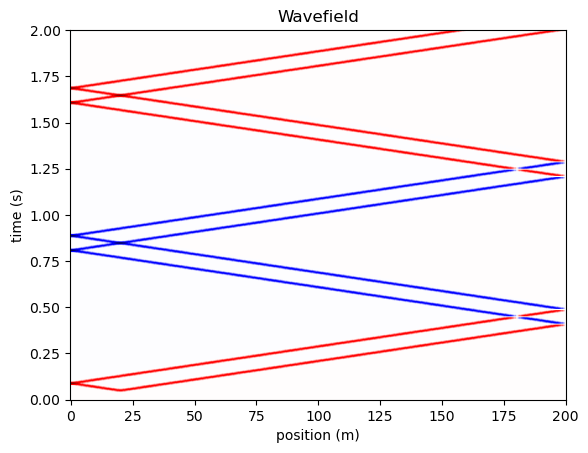

In [327]:
u1 = wave_simulator(xs, ts, v1)

plt.pcolormesh(xs, ts, u1, cmap='seismic', clim=[-1, 1])
plt.title('Wavefield')
plt.xlabel('position (m)')
plt.ylabel('time (s)');

### e)
This time run the wave simulator with a higher velocity $v_2=1000m/s$, and tell me:

* Does it work?
* What is $\frac{\Delta t}{\Delta x} v$ in this case

/var/folders/84/p2kwn61561lg6qxvs6gwhy780000gp/T/ipykernel_23884/2250853108.py:36: RuntimeWarning: overflow encountered in multiply
  gj = velocity[:-1]**2*(ujm1[1:] - ujm1[:-1])
/var/folders/84/p2kwn61561lg6qxvs6gwhy780000gp/T/ipykernel_23884/2250853108.py:39: RuntimeWarning: overflow encountered in subtract
  a * (gj[1:]- gj[:-1])
/var/folders/84/p2kwn61561lg6qxvs6gwhy780000gp/T/ipykernel_23884/2250853108.py:39: RuntimeWarning: invalid value encountered in add
  a * (gj[1:]- gj[:-1])
/var/folders/84/p2kwn61561lg6qxvs6gwhy780000gp/T/ipykernel_23884/2250853108.py:36: RuntimeWarning: invalid value encountered in subtract
  gj = velocity[:-1]**2*(ujm1[1:] - ujm1[:-1])


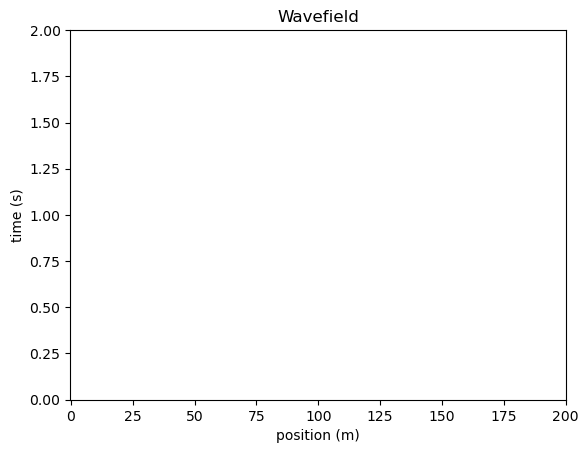

In [328]:
v2 = np.ones_like(xs)*1000 # m/s

u2 = wave_simulator(xs, ts, v2)

plt.pcolormesh(xs, ts, u2, cmap='seismic', clim=[-1, 1])
plt.title('Wavefield')
plt.xlabel('position (m)')
plt.ylabel('time (s)');

### f)
This time run the wave simulator with a lower velocity $v_3=250m/s$, and tell me:

* Does it work?
* What is $\frac{\Delta t}{\Delta x} v$ in this case

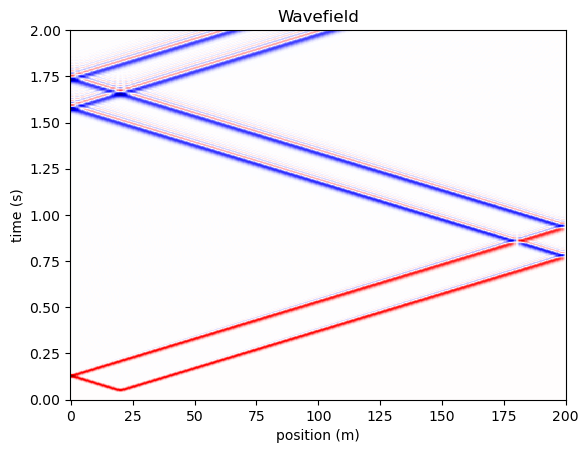

In [329]:
v3 = np.ones_like(xs)*250 # m/s

u3 = wave_simulator(xs, ts, v3)

plt.pcolormesh(xs, ts, u3, cmap='seismic', clim=[-1, 1])
plt.title('Wavefield')
plt.xlabel('position (m)')
plt.ylabel('time (s)');

You might have noticed that it failed when:
$$\frac{\Delta t}{\Delta x} v > 1$$

This is called a stability condition for the numerical PDE! Your simulations will break if you violate this stability condition.

### g)
Now come up with your own velocity model (just remember that your maximum velocity should still not violate the stability condition).

Depending on your conditions, you may notice some numerical dispersion (but it should still at least be solvable if you account for stability).

* Tell me what happens when the wave intersects a boundary!

For example:

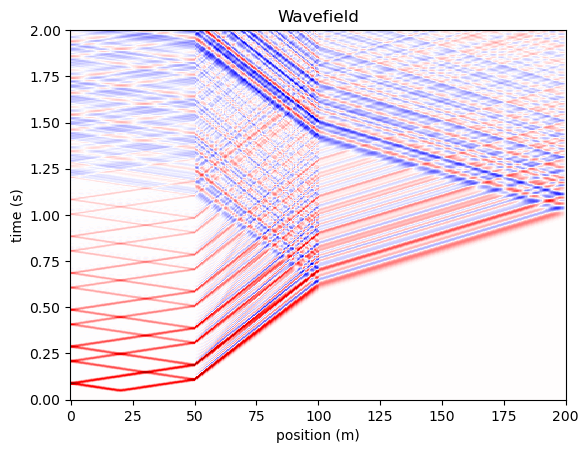

In [330]:
v4 = np.ones_like(xs)*100 # m/s
v4[xs>100] = 250 # m/s
v4[xs<50] = 500

u4 = wave_simulator(xs, ts, v4)

plt.pcolormesh(xs, ts, u4, cmap='seismic', clim=[-1, 1])
plt.title('Wavefield')
plt.xlabel('position (m)')
plt.ylabel('time (s)');